<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries 

In [196]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from math import sqrt
from sklearn.feature_selection import SelectKBest
import random

%matplotlib inline

In [197]:
#Here's a function for DataFrames (again from SO):

from collections import defaultdict

def reverse_dummy(df_dummies):
    pos = defaultdict(list)
    vals = defaultdict(list)

    for i, c in enumerate(df_dummies.columns):
        if "_" in c:
            k, v = c.split("_", 1)
            pos[k].append(i)
            vals[k].append(v)
        else:
            pos["_"].append(i)

    df = pd.DataFrame({k: pd.Categorical.from_codes(
                              np.argmax(df_dummies.iloc[:, pos[k]].values, axis=1),
                              vals[k])
                      for k in vals})

    df[df_dummies.columns[pos["_"]]] = df_dummies.iloc[:, pos["_"]]
    return df


# Correlation Feature Selection

In [198]:
def getMerit(subset, ClassNumerical):
    k = len(subset)
    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr( ClassNumerical, df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )
    
    # average feature-feature correlation
    corr = df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [199]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        """
        item already in priority queue with smaller priority:
        -> update its priority
        item already in priority queue with higher priority:
        -> do nothing
        if item not in priority queue:
        -> push it
        """
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

Load the Dataset from excel (.xlsx file)

In [200]:
# load the dataset
df = pd.read_excel('/content/drive/MyDrive/TesiMagistrale/ExcelForTraining/C2.xlsx')
# Replace NaN with zero on all columns 
df = df.fillna(0)

# name of the label (can be seen in the dataframe)
label = 'Class'
istance = 'Istance'

# list with feature names (V1, V2, V3, ...)
features = df.columns.tolist()
# keep only numerical values
features.remove(label)
features.remove(istance)

# make a label dataframe
labelVec = df.Class
# create dummy variables
labelDummy = pd.get_dummies(labelVec)
labelDummy.columns = list(range(0, len(labelDummy.columns)))

# reverseDummy: change class labeling to 0 and 1
ClassNumerical = pd.DataFrame(labelDummy.idxmax(axis=1))
ClassNumerical.columns = ['Class']
# convert dataframe to series
ClassNumerical = ClassNumerical.squeeze()

In [201]:
best_value = -1
best_feature = ''
for feature in features:

    coeff = pointbiserialr(ClassNumerical, df[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))

Feature app_LT_TKEO_mean_3_coef with merit 0.3983


In [202]:
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

In [203]:
# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 5

In [204]:
# repeat until queue is empty
# or the maximum number of backtracks is reached
while not queue.isEmpty():
    # get element of queue with highest merit
    subset, priority = queue.pop()
    
    # check whether the priority of this subset
    # is higher than the current best subset
    if (priority < best_value):
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # goal condition
    if (n_backtrack == max_backtrack):
        break
    
    # iterate through all features and look of one can
    # increase the merit
    for feature in features:
        temp_subset = subset + [feature]
        
        # check if this subset has already been evaluated
        for node in visited:
            if (set(node) == set(temp_subset)):
                break
        # if not, ...
        else:
            # ... mark it as visited
            visited.append( temp_subset )
            # ... compute merit
            merit = getMerit(temp_subset, ClassNumerical)
            # and push it to the queue
            queue.push(temp_subset, merit)

Show the best subset of features

In [205]:
best_subset

['app_LT_TKEO_mean_3_coef',
 'std_MFCC_3rdCoef',
 'F0__TKEO_perc75',
 'mean_MFCC_3rdCoef',
 'FTrCIP',
 'app_LT_entropy_log_9_coef',
 'mean_MFCC_0thCoef',
 'std_4thDelta',
 'F3_slopeLinFit',
 'IMF__NSR_entropy',
 'mean_5thDelta',
 'F0__TKEO_perc25',
 'std_1stDeltaDelta',
 'app_LT_TKEO_mean_4_coef',
 'mean_6thDelta_delta',
 'F1__TKEO_slopeLinFit',
 'std_3rdDelta_delta']

Merit of the best subset of features

In [206]:
merit

0.6335988842347657

# Information Gain

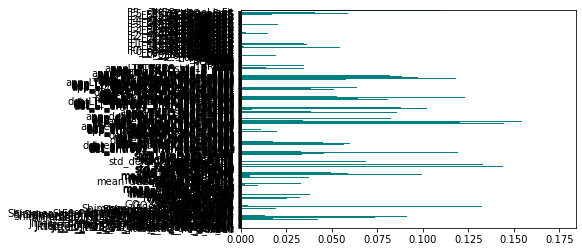

In [207]:
dfIG = df.iloc[: , 1:]
# Drop last column
dfIG.drop(columns=df.columns[-1], 
        axis=1, 
        inplace=True)

importances = mutual_info_classif(dfIG, ClassNumerical)
feat_importances = pd.Series(importances, dfIG.columns[0:len(dfIG.columns)])
feat_importances.plot(kind='barh',color = 'teal')
plt.show()

In [208]:
mutual_info = pd.Series(importances)
mutual_info.index = dfIG.columns
mutual_info.sort_values(ascending=False)

Ed2_1_coef                       0.175221
app_entropy_log_6_coef           0.154380
app_LT_entropy_shannon_1_coef    0.153960
det_LT_entropy_shannon_1_coef    0.148660
app_entropy_log_3_coef           0.147443
                                   ...   
det_TKEO_std_7_coef              0.000000
app_LT_TKEO_std_7_coef           0.000000
det_TKEO_std_6_coef              0.000000
det_TKEO_std_4_coef              0.000000
F0_Mean                          0.000000
Length: 455, dtype: float64

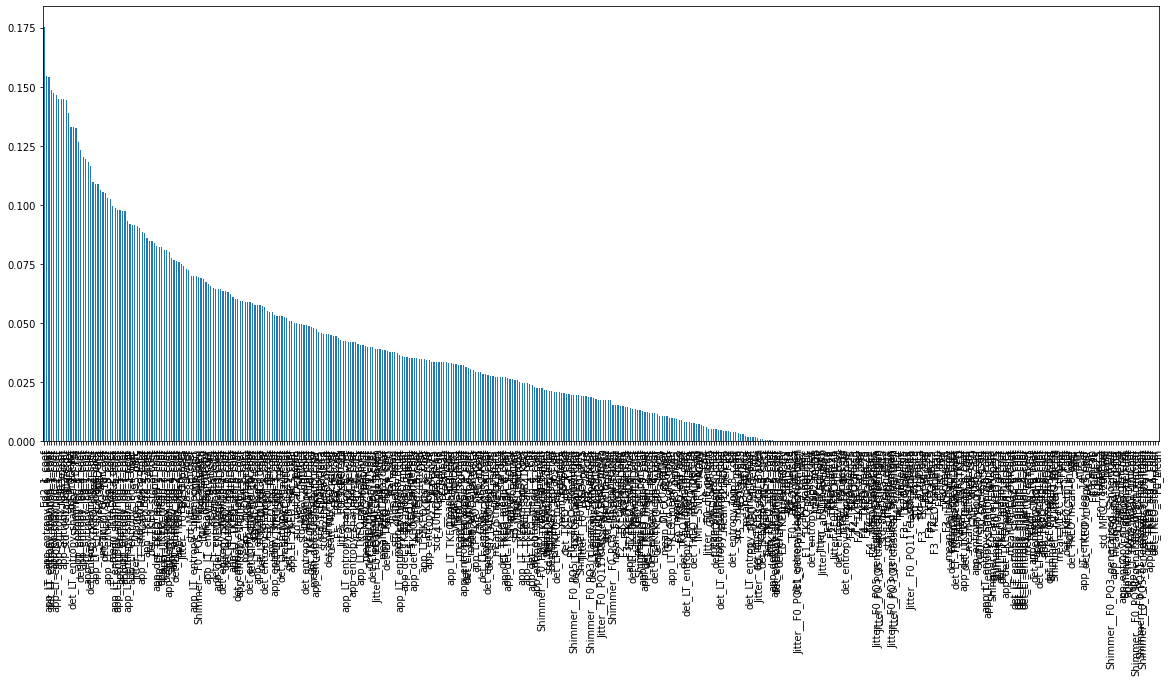

In [209]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [210]:
infogain = pd.DataFrame(mutual_info)
infogain.columns = ['value']
infogain = infogain.sort_values(by=['value'],ascending=False)
infogain = infogain.transpose()

In [211]:
#No we Will select the top k important features
k = 100
IG_k_cols = infogain.iloc[:, :k]
IG_k_cols

,Ed2_1_coef,app_entropy_log_6_coef,app_LT_entropy_shannon_1_coef,det_LT_entropy_shannon_1_coef,app_entropy_log_3_coef,app_LT_entropy_shannon_2_coef,app_entropy_log_1_coef,NHR_mean,app_entropy_log_2_coef,std_deltaLogEnergy,...,det_entropy_shannon_8_coef,F0__TKEO_perc95,F1_perc95,app_TKEO_std_1_coef,app_entropy_shannon_3_coef,det_LT_TKEO_std_7_coef,GNE__mean,det_LT_entropy_log_7_coef,mean_MFCC_12thCoef,std_MFCC_1stCoef
value,0.175221,0.15438,0.15396,0.14866,0.147443,0.146275,0.144959,0.144884,0.144693,0.144307,...,0.056781,0.054968,0.054755,0.05475,0.053584,0.053134,0.05295,0.052787,0.052627,0.052305


# Genetic Algorithm

In [212]:
import time
import random
import pandas as pd
import numpy as np
import copy
import math
import tensorflow
import sklearn
import keras

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import accuracy_score

In [213]:
from keras import backend as K

def recall_fun(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_fun(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_fun(y_true, y_pred):
    precision = precision_fun(y_true, y_pred)
    recall = recall_fun(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [214]:
def generate_dataframes_for_training(dataframe, split_frac=0.8):
    """
    Generates training and testing dataframes from a complete dataframe, according to the split_frac parameter
    """
    train_data = dataframe.sample(frac=split_frac, random_state=314)
    test_data = dataframe.drop(train_data.index)
    
    X_train = train_data.loc[:, train_data.columns != 'Class']
    X_test = test_data.loc[:, test_data.columns != 'Class']
    y_train = train_data.loc[:, train_data.columns == 'Class']
    y_test = test_data.loc[:, test_data.columns == 'Class']

    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [215]:
# GETTER FOR UNIQUE VALUES
def get_uniques(dataframe):
    for feature in dataframe.columns:

        print(f"Feature {feature}: \n{list(pd.Series(dataframe[feature]).unique())}")

In [216]:
# GETTER FOR UNIQUE VALUES
def get_uniques(dataframe):
    for feature in dataframe.columns:

        print(f"Feature {feature}: \n{list(pd.Series(dataframe[feature]).unique())}")

## Functions for Genetic Algorithms

In [217]:
def create_model(X, verbose=False):
    """
    X: training dataset to be used. Its shape is used to set the input shape for the model.
    """
    
    model = Sequential()
    
    model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    if verbose: print('MODEL SUMMARY: \n')
    if verbose: print(model.summary())
    
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [218]:
def get_n_individual(counter, population):
    """
    If counter is 0, return the individual with the highest prob
    If counter is 1, return the second individual with the highest prob
    If counter is 2, return the third individual withthe highest prob
    """
    index = counter + 1
    probabilities = [ind[1] for ind in population]
    sorted_probs = sorted(probabilities, key=float)
    max_prob = probabilities[-index]
    max_individual = [ind[0] for ind in population if ind[1] == max_prob][0]
    
    return max_individual



First, randomly define N possible solutions to the problem

In [219]:
def generate_random_individuals(num_individuals, num_features, max_features=None, verbose=False):
    """
    Randomly generates individuals

    The number of individuals to generate is given by the num_individuals parameter
    The length of each individual is equal to the num_features parameter
    The maximum number of active features for every individual is given by the max_features parameter
    """
    if verbose: print('GENERATING RANDOM INDIVIDUALS.... ')
        
    individuals = list()
    
    for _ in range(num_individuals):
        individual = ''
        for col in range(num_features):
            # For each char in the individual, a 1 or a 0 is randomly generated
            if individual.count('1') == max_features:
                individual += '0'
                continue
                
            individual += str(random.randint(0, 1))
            
        if verbose: print(f'Generated a new individual: {individual}')
        individuals.append(individual)
        
    if verbose: print(f'Generated list of {num_individuals} individuals: {individuals}')
        
    return individuals

Fitness Evaluation of the current individual (= set of features)

Fitness is based on a neural network

In [220]:
def get_fitness_func(individual, dataframe, verbose=False):
    """
    Calculate accuracy for the individual passed as parameter.
    Both the dataframe and the y_data parameters are used for training and evaluating the model.
    """
    if verbose: print('Calculating accuracy for individual ', individual)
    
    # generate_dataframes_for_training() function splits a given dataset into training and test data, 
    # and separates labels and rest of features
    X_train, X_test, y_train, y_test = generate_dataframes_for_training(dataframe)
    
    X_train = X_train.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
    X_test = X_test.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]    
    
    model = create_model(X_train, individual)

    X_train = np.asarray(X_train).astype(np.float64)
    X_test = np.asarray(X_test).astype(np.float64)
    y_train = np.asarray(y_train).astype(np.float64)
    y_test = np.asarray(y_test).astype(np.float64)

    model.fit(X_train, y_train, epochs=100, verbose=0)
    
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred.round())
    if verbose: print(f"Accuracy for the classifier trained for individual {individual}: \n", accuracy,'\n')
    
    return accuracy


Get Weights of the current population (needed in reproduction step)

In [221]:
# This function perform Roulette Wheel Selection
def get_weights_wheel(population):
    """
    Calculate weights from the population filled with the accuracies
    """
    total_accuracies = 0
    new_population = []
    
    # Get the sum of all accuracies of the population
    for individual in population:
        total_accuracies += individual[1]
        
    # For each individual, calculate its weight by dividing its accuracy by the overall sum calculated above
    for individual in population:
        weight = individual[1]/total_accuracies
        # Store the individual and its weight in the final population list
        new_population.append((individual[0], float(weight*100)))
        
    return new_population

# This function perform Rank Selection
def get_weights_rank(population):
    """
    Calculate weights from the population filled with the accuracies
    """
    new_population = []
    N = len(population[0])
    # Use the gauss formula to get the sum of all ranks (sum of integers 1 to N).
    TotalFitness = (N + 1) * N / 2;

    # For each individual, calculate its weight by dividing its accuracy by the overall sum calculated above
    for individual in population:
        weight = individual/TotalFitness
        # Store the individual and its weight in the final population list
        new_population.append((individual[0], float(weight*100)))
        
    return new_population

Evaluate all the individuals one by one

In [222]:
def fill_population(individuals, dataframe, verbose=False):
    """
    Fills the population list with individuals and their weights
    """
    population = list()
    
    for individual in individuals:
        
        # Get the value of the fitness function (accuracy of the model)
        if verbose: 
          print(f'\n Calculating fitness function value for individual {individual} \n')
        
        # Evaluate current individual
        accuracy = get_fitness_func(individual, dataframe, verbose)
        
        # Check that the value is not the goal state (in this case, an accuracy of 80% is a terminal state)
        if float(accuracy) > 0.8:
            if verbose: print(f'Goal state found for individual {individual}')
            return individual
            
        individual_complete = (individual, accuracy)
        population.append(individual_complete)
        
    # The final population list is created, which contains each individual together with its weight
    # (weights will be used in the reproduction step)
    new_population = get_weights_rank(population)
    # Alternative: roulette wheel selection
    #new_population = get_weights_wheel(population)
    if verbose: print(f'Generated population list (with weights): {new_population}')
    
    return new_population

Choose parents and reproduce them

In [223]:
def choose_parents(population, counter):
    """
    From the population, weighting the probabilities of an individual being chosen via the fitness
    function, takes randomly two individual to reproduce
    Population is a list of tuples, where the first element is the individual and the second
    one is the probability associated to it.
    To avoid generating repeated individuals, 'counter' parameter is used to pick parents in different ways, thus
    generating different individuals
    """
    # Pick random parent Number 1 and Number 2
    # (get_n_individual() function randomly picks an individual following the distribution of the weights)
    if counter == 0:        
        parent_1 = get_n_individual(0, population)        
        parent_2 = get_n_individual(1, population)
    elif counter == 1:
        parent_1 = get_n_individual(0, population)        
        parent_2 = get_n_individual(2, population)
        
    else:
        probabilities = (individual[1] for individual in population)
        individuals = [individual[0] for individual in population]
        parent_1, parent_2 = random.choices(individuals, weights=probabilities, k=2)
    
    return [parent_1, parent_2]

def mutate(child, prob=0.1):
    """
    Randomly mutates an individual according to the probability given by prob parameter
    """
    new_child = copy.deepcopy(child)
    for i, char in enumerate(new_child):
        if random.random() < prob:
            new_value = '1' if char == '0' else '0'
            new_child = new_child[:i] + new_value + new_child[i+1:]
    
    return new_child

def reproduce(individual_1, individual_2):
    """
    Takes 2 individuals, and combines their information based on a
    randomly chosen crosspoint.
    Each reproduction returns 2 new individuals
    """ 
    # Randomly generate a integer between 1 and the length of the individuals minus one, which will be the crosspoint
    crosspoint = random.randint(1, len(individual_1)-1)
    child_1 = individual_1[:crosspoint] + individual_2[crosspoint:]
    child_2 = individual_2[:crosspoint] + individual_1[crosspoint:]
    child_1, child_2 = mutate(child_1), mutate(child_2)
 
    return [child_1, child_2]

def generation_ahead(population, verbose=False):
    """
    Reproduces all the steps for choosing parents and making 
    childs, which means creating a new generation to iterate with
    """
    new_population = list()
    
    for _ in range(int(len(population)//2)):      
        # According to the weights calculated before, choose a set of parents to reproduce
        parents = choose_parents(population, counter=_)
        if verbose: print(f'Parents chosen: {parents}')
          
        # Reproduce the pair of individuals chose above to generate two new individuals
        childs = reproduce(parents[0], parents[1])
        if verbose: print(f'Generated children: {childs}\n')
        new_population += childs
        
    return new_population

Main Loop

In [224]:
def main_loop(ind_num, dataframe, max_iter=5, verbose=False):
    """
    Performs all the steps of the Genetic Algorithm
    1. Generate random population
    2. Fill population with the weights of each individual
    3. Check if the goal state is reached
    4. Reproduce the population, and create a new generation
    5. Repeat process until termination condition is met
    """
    num_features = len(dataframe.columns)-1
    # Generate individuals (returns a list of strings, where each str represents an individual)
    individuals = generate_random_individuals(ind_num, num_features, random.randint(round(num_features/5), round(num_features/2)), verbose)
    
    # Returns a list of tuples, where each tuple represents an individual and its weight
    population = fill_population(individuals, dataframe, verbose)
    
    # Check if a goal state is reached
    # When goal state is reached, fill_population() function returns a str, otherwise continue
    if isinstance(population, str):
        # Evaluate current population
        accuracy = get_fitness_func(population, dataframe, verbose)
        return population, accuracy
        
    # Reproduce current generation to generate a better new one
    new_generation = generation_ahead(population, verbose)
    
    # After the new generation is generated, the loop goes on until a solution is found or until the maximum number of
    # iterations are reached
    iteration_count = 0
    while iteration_count < max_iter:
        if verbose: print(f'\n\n\nITERATION NUMBER {iteration_count+1} (Iteration max = {max_iter+1})\n\n\n')
        population = fill_population(new_generation, dataframe, verbose)
        
        # Check if a goal state is reached
        if isinstance(population, str):
            break
        
        new_generation = generation_ahead(population, verbose)   
        iteration_count += 1
        
    return population


Feature Selection

In [225]:
import scipy.stats as stats

# Define Dataframe
dfGA = df.iloc[: , 1:]
# Calculate the z-score from with scipy
dfGA = dfGA.select_dtypes(include='number').apply(stats.zscore)
dataframe = pd.concat([dfGA, pd.DataFrame(ClassNumerical)], axis=1)

In [226]:
# # Create the model
# model = Sequential()
# model.add(Dense(64, input_dim=dfGA.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
  
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# # Generate dataframes for both training and testing
# X_train, X_test, y_train, y_test = generate_dataframes_for_training(dataframe)
# X_train = np.asarray(X_train).astype('float32')
# X_test = np.asarray(X_test).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# y_test = np.asarray(y_test).astype('float32')

In [227]:
# start = time.time()
# model.fit(X_train, y_train, epochs=128, verbose=0)
# print('Time elapsed for training the model with the full dataset: ', time.time() - start, ' seconds')

In [228]:
# pred = model.predict(X_test)
# print('Recall: ', recall_fun(y_test, pred.round()))
# print('Precision: ', precision_fun(y_test, pred.round()))
# print('F1 Score: ', f1_fun(y_test, pred.round()))

In [229]:
start = time.time()
final_population, fitness_accuracy = main_loop(200, dataframe, max_iter = 10, verbose=True)
print('Time elapsed for executing the recursive GA: ', time.time() - start, ' seconds')

GENERATING RANDOM INDIVIDUALS.... 
Generated a new individual: 00111100001010100110100101001000110010111010100000011010110111010001110011010010011001100100100100101101010011011010000011010101111000000100110010000100111111100101010101110111010111111010000011110010111100111110100000111011001100111011011100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Generated a new individual: 001110011000111111110001100111101101010101010100010110111111000010101000100101000111010000010101010101001011111010010101011001001001010010010000110011111110100101101100100110110010101010010100110001000001000101010110100110010111110000011000011000000011011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [230]:
featuresGAall = pd.DataFrame(features).transpose()
selected_featuresGA = featuresGAall.loc[:, [True if char == '1' else False for char in final_population]]
selected_featuresGA

,2,3,4,5,10,12,14,17,18,20,...,226,227,230,231,232,234,235,237,238,239
0,Jitter__F0_abs_dif,Jitter__F0_dif_percent,Jitter__F0_PQ3_classical_Schoentgen,Jitter__F0_PQ3_classical_Baken,Jitter__F0_PQ11_classical_Schoentgen,Jitter__F0_PQ11_generalised_Schoentgen,Jitter__F0_DB,Jitter__F0_TKEO_std,Jitter__F0_TKEO_prc5,Jitter__F0_TKEO_prc75,...,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_std_3_coef


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


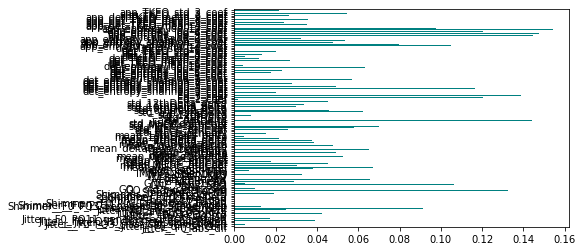

In [231]:
optimized_dataframe = dataframe.loc[:, [True if char == '1' else False for char in final_population+'0']]
optimized_dataframe['Class'] = dataframe['Class']

# Drop last column
optimized_dataframe.drop(columns=df.columns[-1], 
        axis=1, 
        inplace=True)

importances = mutual_info_classif(optimized_dataframe, ClassNumerical)

mutual_info = pd.Series(importances)
mutual_info.index = optimized_dataframe.columns
mutual_info.sort_values(ascending=False, inplace = True)
k = 100
bestkfeatures = mutual_info[0:k]

feat_importances = pd.Series(bestkfeatures, optimized_dataframe.columns[0:len(optimized_dataframe.columns)])
feat_importances.plot(kind='barh',color = 'teal')
plt.show()

In [232]:
# optimized_dataframe = dataframe.loc[:, [True if char == '1' else False for char in final_population+'0']]
# optimized_dataframe['Class'] = dataframe['Class']
# # Create the model
# model = Sequential()
# model.add(Dense(64, input_dim=optimized_dataframe.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
  
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# # Generate dataframes for both training and testing
# X_train, X_test, y_train, y_test = generate_dataframes_for_training(optimized_dataframe)
# X_train = np.asarray(X_train).astype('float32')
# X_test = np.asarray(X_test).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# y_test = np.asarray(y_test).astype('float32')

In [233]:
# start = time.time()
# model.fit(X_train, y_train, epochs=128, verbose=0)
# print('Time elapsed for training the model with the full dataset: ', time.time() - start, ' seconds')

In [234]:
# print('Recall: ', recall_fun(y_test, pred.round()))
# print('Precision: ', precision_fun(y_test, pred.round()))
# print('F1 Score: ', f1_fun(y_test, pred.round()))